Nesessary libraries connected

In [3]:
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
import random
import opendatasets as od

In [4]:
filename = "animals10"
if not os.path.exists(filename):
    print("Downloading the dataset...")
    od.download("https://www.kaggle.com/datasets/alessiocorrado99/animals10")
else:
    print("Dataset file already exists.")

Dataset file already exists.


Categories: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
[[230 230 229 ... 234 235 235]
 [230 230 229 ... 234 234 235]
 [229 229 228 ... 233 234 234]
 ...
 [ 87  86  85 ... 239 239 239]
 [ 86  86  85 ... 239 239 239]
 [ 94  87  82 ... 240 240 239]]


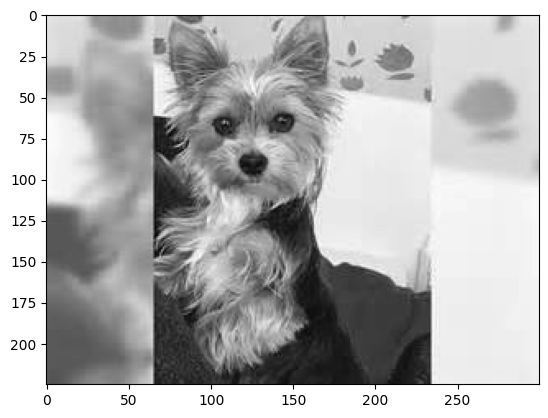

In [5]:
directory = 'animals10/raw-img'

categories = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

print("Categories:", categories)

for cl in categories:
    path = os.path.join(directory, cl)
    for img_path in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_path), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap="gray")
        break
    break

print(img)

In [32]:
animals = []
for cl in categories:
    cls_num = categories.index(cl)
    path = os.path.join(directory, cl)
    for img in os.listdir(path):
        try:
            img = cv2.imread(os.path.join(path, img))
            resized_img = cv2.resize(img, (128,128))
            resized_img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
            animals.append([resized_img_gray, cls_num])
        except Exception as e:
            pass

random.shuffle(animals)
for i in animals[:10]:
    print(categories[i[1]])

farfalla
ragno
gatto
scoiattolo
ragno
cane
gallina
gallina
cane
gatto


In [33]:
x = []
y = []

for idx, (pic, label) in enumerate(animals):
    resized_pic = cv2.resize(pic, (128, 128))
    x.append(resized_pic)
    y.append(label)

x = np.array(x).reshape(-1, 128,128, 1)
print(f"Images length: {len(x)}")
print(f"Labels length: {len(y)}")

Images length: 26179
Labels length: 26179


In [42]:
# Define a CustomConv2D layer to handle multiple filters
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer=None, padding="valid", activation=None, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        # Use predefined kernels if provided, otherwise initialize normally
        kernel_shape = (*self.kernel_size, input_shape[-1], self.filters)
        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer=tf.constant_initializer(self.kernel_initializer),
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer="glorot_uniform",
                                          trainable=True)


        # Initialize biases for each filter
        self.bias = self.add_weight(name="bias",
                                    shape=(self.filters,),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        # Perform the convolution using multiple filters
        output = tf.nn.conv2d(inputs, self.kernel, strides=1, padding=self.padding.upper())
        # Add bias and apply the activation function, if specified
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

# Define example filters

sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

sharpening_filter = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])  # Horizontal edge

# Stack the filters to shape (3, 3, 1, 3) for compatibility with CustomConv2D
predefined_kernels = np.stack([sobel_x, sobel_y, sharpening_filter], axis=-1)
predefined_kernels = np.expand_dims(predefined_kernels, axis=-2)  # Shape (3, 3, 1, 3)

x = x / 255.0

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, random_state = 0)

# Define the CNN model with the CustomConv2D layer
model = tf.keras.Sequential([

    CustomConv2D(filters=3, kernel_size=(3, 3), kernel_initializer=predefined_kernels, padding="same", activation="relu", input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary to verify setup
model.summary()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Train the model (optional, requires the full dataset and a longer training process)
model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

# Evaluate the model (optional)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

C:\Users\bprid\AppData\Local\Temp\ipykernel_14952\3144055886.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(CustomConv2D, self).__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d_24 (CustomConv2D) │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │       122,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,920 (480.16 KB)

 Trainable params: 122,920 (480.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1765 - loss: 2.2763 - val_accuracy: 0.1838 - val_loss: 2.2268
Epoch 2/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1854 - loss: 2.2212 - val_accuracy: 0.1874 - val_loss: 2.2100
Epoch 3/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1885 - loss: 2.2095 - val_accuracy: 0.1838 - val_loss: 2.2072
Epoch 4/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1831 - loss: 2.2055 - val_accuracy: 0.1838 - val_loss: 2.2068
Epoch 5/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1824 - loss: 2.2066 - val_accuracy: 0.1838 - val_loss: 2.2067
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1905 - loss: 2.1966
Test accuracy: 0.18239113688468933


data augmentation

In [37]:
def image_resizing(images):
    resized_images = []
    for idx, image in enumerate(images):
        try:
            # Ensure image is valid
            if not isinstance(image, np.ndarray) or image.shape is None:
                print(f"Skipping invalid input at index {idx}")
                continue

            #print(f"Resizing image {idx}: Original Shape={image.shape}")

            # Resize to 50x50
            resized_image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
            print(f"Resizing image {idx}: Resized Shape={resized_image.shape}")
            resized_images.append(resized_image)
        except Exception as e:
            print(f"Failed to resize image at index {idx}: {e}")

    print(f"Total resized images: {len(resized_images)}")
    return resized_images

In [5]:
def image_processing(images):
    processed_images = []
    for image in range(len(images)):
        #processed_images = cv2.GaussianBlur(images[i], (3, 3), 0) #removing noise from the images
        image = cv2.medianBlur(images[i], 5) #removing noise from the images
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY) #converting images to grayscale
        image = cv2.equalizeHist(images[i]) #histogram equalization
        #processed_images = cv2.Canny(images[i], 100, 200) #edge detection which does not work in favour of neural network recognition
        processed_images.append(image)
    return processed_images

In [6]:
def shuffle_images(images):
  random.shuffle(images)
  return images

Total images loaded: 26179
Resizing image 0: Resized Shape=(128, 128, 3)
Resizing image 1: Resized Shape=(128, 128, 3)
Resizing image 2: Resized Shape=(128, 128, 3)
Resizing image 3: Resized Shape=(128, 128, 3)
Resizing image 4: Resized Shape=(128, 128, 3)
Resizing image 5: Resized Shape=(128, 128, 3)
Resizing image 6: Resized Shape=(128, 128, 3)
Resizing image 7: Resized Shape=(128, 128, 3)
Resizing image 8: Resized Shape=(128, 128, 3)
Resizing image 9: Resized Shape=(128, 128, 3)
Resizing image 10: Resized Shape=(128, 128, 3)
Resizing image 11: Resized Shape=(128, 128, 3)
Resizing image 12: Resized Shape=(128, 128, 3)
Resizing image 13: Resized Shape=(128, 128, 3)
Resizing image 14: Resized Shape=(128, 128, 3)
Resizing image 15: Resized Shape=(128, 128, 3)
Resizing image 16: Resized Shape=(128, 128, 3)
Resizing image 17: Resized Shape=(128, 128, 3)
Resizing image 18: Resized Shape=(128, 128, 3)
Resizing image 19: Resized Shape=(128, 128, 3)
Resizing image 20: Resized Shape=(128, 128,

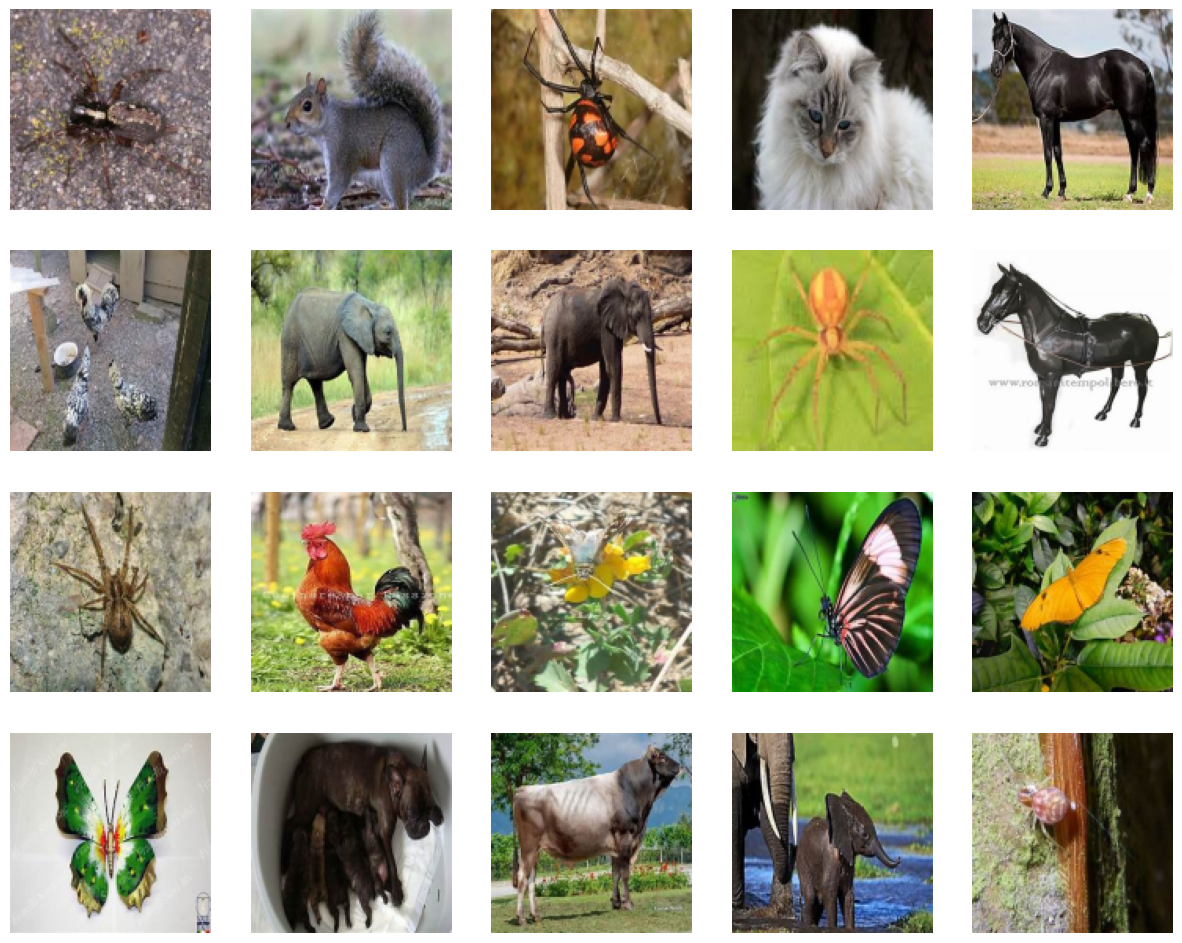

In [42]:
rootdir = 'animals10/raw-img'
images = []
labels = []

# Load images
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
                labels.append(label)
            else:
                print(f"Could not load image: {image_path}")

print(f"Total images loaded: {len(images)}")

shuffled_images = shuffle_images(images)
#processed_images = image_processing(shuffled_images)
resized_images = image_resizing(shuffled_images)

# Display images
num_display = min(20, len(resized_images))
num_rows = (num_display + 4) // 5
plt.figure(figsize=(15, num_rows * 3))
for i, img in enumerate(resized_images[:num_display]):
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

In [44]:
# Define a CustomConv2D layer to handle multiple filters
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer=None, padding="valid", activation=None, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        # Use predefined kernels if provided, otherwise initialize normally
        kernel_shape = (*self.kernel_size, input_shape[-1], self.filters)
        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer=tf.constant_initializer(self.kernel_initializer),
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer="glorot_uniform",
                                          trainable=True)


        # Initialize biases for each filter
        self.bias = self.add_weight(name="bias",
                                    shape=(self.filters,),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        # Perform the convolution using multiple filters
        output = tf.nn.conv2d(inputs, self.kernel, strides=1, padding=self.padding.upper())
        # Add bias and apply the activation function, if specified
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

# Define example filters

filter_1 = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]])  # Identity Matrix

filter_2 = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]])       # Vertical edge

filter_3 = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]])       # Horizontal edge

# Stack the filters to shape (3, 3, 1, 3) for compatibility with CustomConv2D
predefined_kernels = np.stack([filter_1, filter_2, filter_3], axis=-1)
predefined_kernels = np.expand_dims(predefined_kernels, axis=-2)  # Shape (3, 3, 1, 3)

for idx, img in enumerate(resized_images):
    try:
        print(f"Image {idx}: Shape={getattr(img, 'shape', 'Not a valid array')}")
    except Exception as e:
        print(f"Error with image {idx}: {e}")

# Convert lists to numpy arrays
x_data = np.array(resized_images, dtype=np.float32)  # Ensure images are of dtype float32
x_data = x_data[..., tf.newaxis]  # Add channel dimension to make it (50, 50, 1)

# Create a mapping dictionary
label_mapping = {label: idx for idx, label in enumerate(set(labels))}

# Convert string labels to numeric values using the mapping
numeric_labels = [label_mapping[label] for label in labels]

# Convert to NumPy array
y_data = np.array(numeric_labels, dtype=np.int32)
num_classes = len(np.unique(y_data))

# Split into training and testing datasets (e.g., 80% train, 20% test)
split_index = int(0.8 * len(x_data))
x_train, y_train = x_data[:split_index], y_data[:split_index]
x_test, y_test = x_data[split_index:], y_data[split_index:]

# Define the CNN model with the CustomConv2D layer
model = tf.keras.Sequential([
    CustomConv2D(filters=3, kernel_size=(3, 3), kernel_initializer=predefined_kernels, padding="same", activation="relu", input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary to verify setup
model.summary()

# Train the model (optional, requires the full dataset and a longer training process)
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Evaluate the model (optional)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

Image 0: Shape=(128, 128, 3)
Image 1: Shape=(128, 128, 3)
Image 2: Shape=(128, 128, 3)
Image 3: Shape=(128, 128, 3)
Image 4: Shape=(128, 128, 3)
Image 5: Shape=(128, 128, 3)
Image 6: Shape=(128, 128, 3)
Image 7: Shape=(128, 128, 3)
Image 8: Shape=(128, 128, 3)
Image 9: Shape=(128, 128, 3)
Image 10: Shape=(128, 128, 3)
Image 11: Shape=(128, 128, 3)
Image 12: Shape=(128, 128, 3)
Image 13: Shape=(128, 128, 3)
Image 14: Shape=(128, 128, 3)
Image 15: Shape=(128, 128, 3)
Image 16: Shape=(128, 128, 3)
Image 17: Shape=(128, 128, 3)
Image 18: Shape=(128, 128, 3)
Image 19: Shape=(128, 128, 3)
Image 20: Shape=(128, 128, 3)
Image 21: Shape=(128, 128, 3)
Image 22: Shape=(128, 128, 3)
Image 23: Shape=(128, 128, 3)
Image 24: Shape=(128, 128, 3)
Image 25: Shape=(128, 128, 3)
Image 26: Shape=(128, 128, 3)
Image 27: Shape=(128, 128, 3)
Image 28: Shape=(128, 128, 3)
Image 29: Shape=(128, 128, 3)
Image 30: Shape=(128, 128, 3)
Image 31: Shape=(128, 128, 3)
Image 32: Shape=(128, 128, 3)
Image 33: Shape=(128

C:\Users\bprid\AppData\Local\Temp\ipykernel_21924\551449163.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(CustomConv2D, self).__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d_20 (CustomConv2D) │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │       122,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,920 (480.16 KB)

 Trainable params: 122,920 (480.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1347 - loss: 182.9773 - val_accuracy: 0.0619 - val_loss: 174.9740
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2270 - loss: 18.5292 - val_accuracy: 0.0300 - val_loss: 72.4752
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2757 - loss: 6.8650 - val_accuracy: 0.0451 - val_loss: 34.0835
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3189 - loss: 3.5119 - val_accuracy: 0.0435 - val_loss: 17.8589
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3568 - loss: 2.5569 - val_accuracy: 0.0430 - val_loss: 15.1707
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0614 - loss: 7.9091
Test accuracy: 0.04297173395752907
